In [2]:
import requests, bs4, os, errno, time, datetime, re
import plac
from spacy.lang.en import English
from spacy.matcher import PhraseMatcher
from spacy.tokens import Doc, Span, Token


In [5]:
def download_page(url):
    try:
        page = requests.get(url, timeout=10.0)
    except requests.exceptions.Timeout:
        print('Timeout\n')
        return None
    except requests.exceptions.ConnectionError:
        print('ConnectionError\n')
        time.sleep(120)
        return None
    except requests.exceptions.HTTPError:
        print('HTTPError\n')
        return None
    except requests.exceptions.TooManyRedirects:
        print('TooManyRedirects\n')
        return None
    else:
        return page

In [9]:
max_attempts = 10

r_unwanted = re.compile('[\n\t\r]')

urls_to_articles = []

if not os.path.exists('articles/'):
    try:
        os.makedirs('articles/')
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise

# STEP 1. BUILD THE LIST OF URLS TO ARTICLES
if True:
#not os.path.exists('urls_to_articles.txt'):
    links_to_parts = []

    for year in range(2019, datetime.datetime.now().year + 1):

        catalog_page_by_years = 'http://spiderbites.nytimes.com/%s/' % (year)

        attempts = 0

        print('Year: ', year)

        with open('logfile.log', 'w') as f:
            f.write('STEP 1. Year: ' + str(year) + '\n')

        catalog_page = download_page(catalog_page_by_years)

        while not (catalog_page or attempts > max_attempts):
            catalog_page = download_page(catalog_page_by_years)
            attempts += 1
            
        if catalog_page:
            catalog_page = bs4.BeautifulSoup(catalog_page.text, "lxml")
            if year > 1995:
                links_to_parts.append(['http://spiderbites.nytimes.com%s' % (el.get('href')) for el in catalog_page.select('body > div > div > div > div > div > div > ul > li > a')])
            else:
                links_to_parts.append(['http://spiderbites.nytimes.com/free_%s/%s' % (year, el.get('href')) for el in catalog_page.select('body > div > div > div > div > div > div > ul > li > a')])

    links_to_parts = [item for sublist in links_to_parts for item in sublist]
    
    for link_to_parts in links_to_parts:

        attempts = 0

        parts_page = download_page(link_to_parts)

        while not (parts_page or attempts > max_attempts):
            parts_page = download_page(link_to_parts)
            attempts += 1

        if parts_page:
            parts_page = bs4.BeautifulSoup(parts_page.text, "lxml")
            urls_to_articles.append([el.get('href') for el in parts_page.select('body > div > div > div > div > ul > li > a')])

urls_to_articles = [item for sublist in urls_to_articles for item in sublist]

# Backing up the list of URLs
with open('urls_to_articles.txt', 'w') as output:
    for u in urls_to_articles:
        output.write('%s\n' % (u.strip()))

Year:  2019


In [10]:
#urls_to_articles = [item for sublist in urls_to_articles for item in sublist]
print(urls_to_articles)

['https://www.nytimes.com/2019/01/18/opinion/buzzfeed-cohen-trump-tower.html', 'https://www.nytimes.com/2019/01/08/opinion/green-new-deal.html', 'https://www.nytimes.com/2019/01/11/opinion/trump-2020-media.html', 'https://www.nytimes.com/2019/01/31/opinion/letters/women-metoo-davos.html', 'https://www.nytimes.com/2019/01/02/realestate/1-million-homes-in-minnesota-mississippi-and-washington.html', 'https://www.nytimes.com/2019/01/23/realestate/1-3-million-homes-in-louisiana-new-york-and-california.html', 'https://www.nytimes.com/2019/01/30/realestate/1-5-million-homes-in-california-virginia-and-texas.html', 'https://www.nytimes.com/2019/01/23/nyregion/new-jersey-minimum-wage.html', 'https://www.nytimes.com/2019/01/11/us/vegetative-state-birth-medicaid-fraud.html', 'https://www.nytimes.com/2019/01/11/world/europe/bollywood-sheikh-london-bahrain.html', 'https://www.nytimes.com/2019/01/09/realestate/450000-homes-in-ohio-massachusetts-and-north-carolina.html', 'https://www.nytimes.com/2019/

In [11]:
# STEP 2. DOWNLOAD ARTICLES
    # If, at some point, Step 2 is interrupted due to unforeseen
    # circumstances (power outage, loss of internet connection), replace the number
    # (value of the variable url_num) below with the one you will find in the logfile.log
url_num = 0

if os.path.exists('urls_to_articles.txt') and len(urls_to_articles) == 0:
    with open('urls_to_articles.txt', 'r') as f:
        urls_to_articles = f.read().splitlines()

print('Number of articles that are about to be downloaded: ', len(urls_to_articles))

for url in urls_to_articles[url_num:]:

    if len(url) > 34:

        attempts = 0

        if url_num % 1000 == 0:

            print('Downloading article #', url_num, ' from ', url)

            with open('logfile.log', 'w') as f:
                f.write('STEP 2. Downloading article #' + str(url_num) + ' from ' + url + '\n')

        article_page = download_page(url)

        while not (article_page or attempts > max_attempts):
            article_page = download_page(url)
            attempts += 1

        if article_page:
            article_page = bs4.BeautifulSoup(article_page.text, "lxml")

            title = [el.getText() for el in article_page.find_all(class_="articleHeadline")]
            if len(title) > 0:
                title = title[0]
            else:
                title = [el.getText() for el in article_page.find_all(class_="headline")]

                if len(title) > 0:
                    title = title[0]
                else:
                    title = ""

            dateline = [el.getText() for el in article_page.find_all(class_="dateline")]
            if len(dateline) > 0:
                dateline = dateline[0]
            else:
                dateline = ""

            byline = [el.getText().strip() for el in article_page.find_all(class_="byline")]
            if len(byline) > 0:
                byline = ' '.join(byline)
            else:
                byline = ""

            body = [el.getText() for el in article_page.find_all(class_="articleBody")]
            if len(body) > 0:
                body = '\n'.join(body)
                body = r_unwanted.sub("", body)
                body = re.sub(' +', ' ', body)

                with open('articles/' + str(url_num) + url.split('/')[-1] + '.txt', 'w') as output:
                    output.write('(c) ' + str(datetime.datetime.now().year) + ' The New York Times Company\n')
                    output.write(url + '\n')
                    output.write(title + '\n')
                    output.write(dateline + '\n')
                    output.write(byline + '\n')
                    output.write('\n' + body)
            else:

                body = [el.getText() for el in article_page.find_all(class_="story-body-text")]

                if len(body) > 0:
                    body = '\n'.join(body)
                    body = r_unwanted.sub("", body)
                    body = re.sub(' +', ' ', body)

                    with open('articles/' + str(url_num) + url.split('/')[-1] + '.txt', 'w') as output:
                        output.write('(c) ' + str(datetime.datetime.now().year) + ' The New York Times Company\n')
                        output.write(url + '\n')
                        output.write(title + '\n')
                        output.write(dateline + '\n')
                        output.write(byline + '\n')
                        output.write('\n' + body)
    url_num += 1

Number of articles that are about to be downloaded:  27483


KeyboardInterrupt: 

In [31]:
articles = []
for url in urls_to_articles:
    article_page = download_page(url)
    if article_page:
        article_page = bs4.BeautifulSoup(article_page.text, "lxml")
        body = article_page.find_all(class_="meteredContent")
        if body:
            articles.append(body[0].text)
print(articles)

OSError: Could not find a suitable TLS CA certificate bundle, invalid path: /Users/joshsolis/anaconda3/lib/python3.6/site-packages/certifi/cacert.pem

In [ ]:
# Next step is capturing content from text above

nlp = English()
    if not companies:  # set default companies if none are set via args
        companies = ["Alphabet Inc.", "Google", "Netflix", "Apple"]  # etc.
    component = TechCompanyRecognizer(nlp, companies)  # initialise component
    nlp.add_pipe(component, last=True)  # add last to the pipeline

    doc = nlp(text)
    print("Pipeline", nlp.pipe_names)  # pipeline contains component name
    print("Tokens", [t.text for t in doc])  # company names from the list are merged
    print("Doc has_tech_org", doc._.has_tech_org)  # Doc contains tech orgs
    print("Token 0 is_tech_org", doc[0]._.is_tech_org)  # "Alphabet Inc." is a tech org
    print("Token 1 is_tech_org", doc[1]._.is_tech_org)  # "is" is not
    print("Entities", [(e.text, e.label_) for e in doc.ents])  # all orgs are entities


class TechCompanyRecognizer(object):
    """Example of a spaCy v2.0 pipeline component that sets entity annotations
    based on list of single or multiple-word company names. Companies are
    labelled as ORG and their spans are merged into one token. Additionally,
    ._.has_tech_org and ._.is_tech_org is set on the Doc/Span and Token
    respectively."""

    name = "tech_companies"  # component name, will show up in the pipeline

    def __init__(self, nlp, companies=tuple(), label="ORG"):
        """Initialise the pipeline component. The shared nlp instance is used
        to initialise the matcher with the shared vocab, get the label ID and
        generate Doc objects as phrase match patterns.
        """
        self.label = nlp.vocab.strings[label]  # get entity label ID

        # Set up the PhraseMatcher – it can now take Doc objects as patterns,
        # so even if the list of companies is long, it's very efficient
        patterns = [nlp(org) for org in companies]
        self.matcher = PhraseMatcher(nlp.vocab)
        self.matcher.add("TECH_ORGS", None, *patterns)

        # Register attribute on the Token. We'll be overwriting this based on
        # the matches, so we're only setting a default value, not a getter.
        Token.set_extension("is_tech_org", default=False)

        # Register attributes on Doc and Span via a getter that checks if one of
        # the contained tokens is set to is_tech_org == True.
        Doc.set_extension("has_tech_org", getter=self.has_tech_org)
        Span.set_extension("has_tech_org", getter=self.has_tech_org)

    def __call__(self, doc):
        """Apply the pipeline component on a Doc object and modify it if matches
        are found. Return the Doc, so it can be processed by the next component
        in the pipeline, if available.
        """
        matches = self.matcher(doc)
        spans = []  # keep the spans for later so we can merge them afterwards
        for _, start, end in matches:
            # Generate Span representing the entity & set label
            entity = Span(doc, start, end, label=self.label)
            spans.append(entity)
            # Set custom attribute on each token of the entity
            for token in entity:
                token._.set("is_tech_org", True)
            # Overwrite doc.ents and add entity – be careful not to replace!
            doc.ents = list(doc.ents) + [entity]
        for span in spans:
            # Iterate over all spans and merge them into one token. This is done
            # after setting the entities – otherwise, it would cause mismatched
            # indices!
            span.merge()
        return doc  # don't forget to return the Doc!

    def has_tech_org(self, tokens):
        """Getter for Doc and Span attributes. Returns True if one of the tokens
        is a tech org. Since the getter is only called when we access the
        attribute, we can refer to the Token's 'is_tech_org' attribute here,
        which is already set in the processing step."""
        return any([t._.get("is_tech_org") for t in tokens])

    
    

main()

In [23]:
!pip3 install spacy

You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
!conda install -c conda-forge spacy


Solving environment: done

# All requested packages already installed.



In [2]:
!python -m spacy download en

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/Users/joshsolis/anaconda3/lib/python3.6/site-packages/en_core_web_sm -->
/Users/joshsolis/anaconda3/lib/python3.6/site-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [4]:
from __future__ import unicode_literals, print_function

import spacy
from spacy.lang.en import English
from spacy.matcher import PhraseMatcher
from spacy.tokens import Doc, Span, Token
import pickle
import itertools

pickle_in = open("articles_list.pkl","rb")
texts = pickle.load(pickle_in)

companies=("Names of technology companies", "positional", None, str)

def main(text=texts, *companies):
    # For simplicity, we start off with only the blank English Language class
    # and no model or pre-defined pipeline loaded.
    nlp = spacy.load("en")
    
    '''
    if not companies:  # set default companies if none are set via args
        companies = ["Alphabet Inc.", "Google", "Netflix", "Apple"]  # etc.
    component = TechCompanyRecognizer(nlp, companies)  # initialise component
    nlp.add_pipe(component, last=True)  # add last to the pipeline
    '''
    counts = {}
    '''
    for text in texts
        doc = nlp(text)
    '''
    for text in texts:
        doc = nlp(text)

        combos = list(itertools.combinations([e.text for e in doc.ents if e.label_ == 'ORG'], 2))
        combos = [combo for combo in combos if combo[0] != combo[1]]

        for combo in combos:    
            if combo not in counts:
                counts[combo] = 1
            else:
                counts[combo] += 1
        
    combo_counts = sorted(counts.items(), key = lambda kv:(kv[1], kv[0]))
    #print("Pipeline", nlp.pipe_names)  # pipeline contains component name
    #print("Tokens", [t.text for t in doc])  # company names from the list are merged
    #print("Doc has_tech_org", doc._.has_tech_org)  # Doc contains tech orgs
    #print("Token 0 is_tech_org", doc[0]._.is_tech_org)  # "Alphabet Inc." is a tech org
    #print("Token 1 is_tech_org", doc[1]._.is_tech_org)  # "is" is not
    #print("Entities", [(e.text, e.label_) for e in doc.ents if e.label_ == 'ORG'])  # all orgs are entities
    
    return combo_counts



class TechCompanyRecognizer(object):
    """Example of a spaCy v2.0 pipeline component that sets entity annotations
    based on list of single or multiple-word company names. Companies are
    labelled as ORG and their spans are merged into one token. Additionally,
    ._.has_tech_org and ._.is_tech_org is set on the Doc/Span and Token
    respectively."""

    name = "tech_companies"  # component name, will show up in the pipeline

    def __init__(self, nlp, companies=tuple(), label="ORG"):
        """Initialise the pipeline component. The shared nlp instance is used
        to initialise the matcher with the shared vocab, get the label ID and
        generate Doc objects as phrase match patterns.
        """
        self.label = nlp.vocab.strings[label]  # get entity label ID

        # Set up the PhraseMatcher – it can now take Doc objects as patterns,
        # so even if the list of companies is long, it's very efficient
        patterns = [nlp(org) for org in companies]
        self.matcher = PhraseMatcher(nlp.vocab)
        self.matcher.add("TECH_ORGS", None, *patterns)

        # Register attribute on the Token. We'll be overwriting this based on
        # the matches, so we're only setting a default value, not a getter.
        Token.set_extension("is_tech_org", default=False)

        # Register attributes on Doc and Span via a getter that checks if one of
        # the contained tokens is set to is_tech_org == True.
        Doc.set_extension("has_tech_org", getter=self.has_tech_org)
        Span.set_extension("has_tech_org", getter=self.has_tech_org)

    def __call__(self, doc):
        """Apply the pipeline component on a Doc object and modify it if matches
        are found. Return the Doc, so it can be processed by the next component
        in the pipeline, if available.
        """
        matches = self.matcher(doc)
        spans = []  # keep the spans for later so we can merge them afterwards
        for _, start, end in matches:
            # Generate Span representing the entity & set label
            entity = Span(doc, start, end, label=self.label)
            spans.append(entity)
            # Set custom attribute on each token of the entity
            for token in entity:
                token._.set("is_tech_org", True)
            # Overwrite doc.ents and add entity – be careful not to replace!
            doc.ents = list(doc.ents) + [entity]
        for span in spans:
            # Iterate over all spans and merge them into one token. This is done
            # after setting the entities – otherwise, it would cause mismatched
            # indices!
            span.merge()
        return doc  # don't forget to return the Doc!

    def has_tech_org(self, tokens):
        """Getter for Doc and Span attributes. Returns True if one of the tokens
        is a tech org. Since the getter is only called when we access the
        attribute, we can refer to the Token's 'is_tech_org' attribute here,
        which is already set in the processing step."""
        return any([t._.get("is_tech_org") for t in tokens])

combo_counts = main()

    # Expected output:
    # Pipeline ['tech_companies']
    # Tokens ['Alphabet Inc.', 'is', 'the', 'company', 'behind', 'Google', '.']
    # Doc has_tech_org True
    # Token 0 is_tech_org True
    # Token 1 is_tech_org False
    # Entities [('Alphabet Inc.', 'ORG'), ('Google', 'ORG')]

In [23]:
combo_counts = sorted(combo_counts, key=lambda x: x[1], reverse=True)

combo_counts

[(('Congress', 'Trump'), 6052),
 (('Trump', 'Congress'), 4901),
 (('the European Union', 'E.U.'), 3900),
 (('White House', 'Trump'), 2900),
 (('Trump', 'White House'), 2777),
 (('Trump', 'Times'), 2609),
 (('the European Union', 'the Federal Trade Commission'), 2456),
 (('Nissan', 'Renault'), 2157),
 (('Trump', 'Senate'), 2096),
 (('Microsoft', 'IntersectionObserver'), 1859),
 (('&&', 'the Federal Trade Commission'), 1704),
 (('Medicare', 'TODD'), 1600),
 (('Trump', 'The New York Times Opinion'), 1488),
 (('White House', 'the White House'), 1475),
 (('the White House', 'Congress'), 1397),
 (('the Justice Department', 'Trump'), 1355),
 (('Congress', 'the White House'), 1345),
 (('Parklife', 'NYT'), 1326),
 (('N.B.A.', 'Raptors'), 1316),
 (('E.U.', 'HTML'), 1278),
 (('the European Union', 'European Union'), 1240),
 (('The New York Times', 'Trump'), 1190),
 (('Google', 'Amazon'), 1172),
 (('IP', 'E.U.'), 1158),
 (('the European Union', 'Social Security'), 1140),
 (('&&', 'the Health Insur

In [27]:
for combo in combo_counts:
    if combo[0][0] == "’s" or combo[0][1] == "’s":
        combo_counts.remove(combo)
    elif combo[0][0] == "&&" or combo[0][1] == "&&":
        combo_counts.remove(combo)
    elif len(combo[0][0]) > 20 or len(combo[0][1]) > 20:
        combo_counts.remove(combo)
combo_counts

[(('Congress', 'Trump'), 6052),
 (('Trump', 'Congress'), 4901),
 (('the European Union', 'E.U.'), 3900),
 (('White House', 'Trump'), 2900),
 (('Trump', 'White House'), 2777),
 (('Trump', 'Times'), 2609),
 (('Nissan', 'Renault'), 2157),
 (('Trump', 'Senate'), 2096),
 (('Microsoft', 'IntersectionObserver'), 1859),
 (('Medicare', 'TODD'), 1600),
 (('White House', 'the White House'), 1475),
 (('the White House', 'Congress'), 1397),
 (('Congress', 'the White House'), 1345),
 (('Parklife', 'NYT'), 1326),
 (('N.B.A.', 'Raptors'), 1316),
 (('E.U.', 'HTML'), 1278),
 (('the European Union', 'European Union'), 1240),
 (('The New York Times', 'Trump'), 1190),
 (('Google', 'Amazon'), 1172),
 (('IP', 'E.U.'), 1158),
 (('the European Union', 'Social Security'), 1140),
 (('Trump', 'F.B.I.'), 1121),
 (('Times', 'Trump'), 1113),
 (('Trump', 'The New York Times'), 1068),
 (('Medicare', 'Senate'), 1044),
 (('N.R.A.', 'Ackerman'), 1039),
 (('Leonard', 'Raptors'), 1009),
 (('Congress', 'Times'), 1001),
 (('

In [28]:
import pandas as pd
df = pd.DataFrame(combo_counts)

df.head()



,0,1
0,"(Congress, Trump)",6052
1,"(Trump, Congress)",4901
2,"(the European Union, E.U.)",3900
3,"(White House, Trump)",2900
4,"(Trump, White House)",2777


In [32]:
df.columns = ["ORGS", "Occurences"]

In [33]:
df.head()

,ORGS,Occurences
0,"(Congress, Trump)",6052
1,"(Trump, Congress)",4901
2,"(the European Union, E.U.)",3900
3,"(White House, Trump)",2900
4,"(Trump, White House)",2777


In [39]:
df.hist

<bound method hist_frame of                                                      ORGS  Occurences
0                                       (Congress, Trump)        6052
1                                       (Trump, Congress)        4901
2                              (the European Union, E.U.)        3900
3                                    (White House, Trump)        2900
4                                    (Trump, White House)        2777
5                                          (Trump, Times)        2609
6                                       (Nissan, Renault)        2157
7                                         (Trump, Senate)        2096
8                       (Microsoft, IntersectionObserver)        1859
9                                        (Medicare, TODD)        1600
10                         (White House, the White House)        1475
11                            (the White House, Congress)        1397
12                            (Congress, the White House)     

In [46]:
df = df[df.Occurences >= 20]

df.head()

,ORGS,Occurences
0,"(Congress, Trump)",6052
1,"(Trump, Congress)",4901
2,"(the European Union, E.U.)",3900
3,"(White House, Trump)",2900
4,"(Trump, White House)",2777


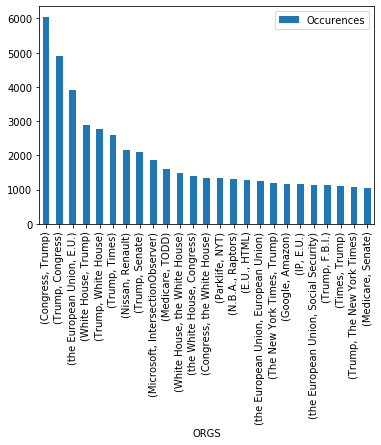

In [56]:
import matplotlib.pyplot as plt
import numpy as np

df[:25].plot(kind='bar', x = 'ORGS')


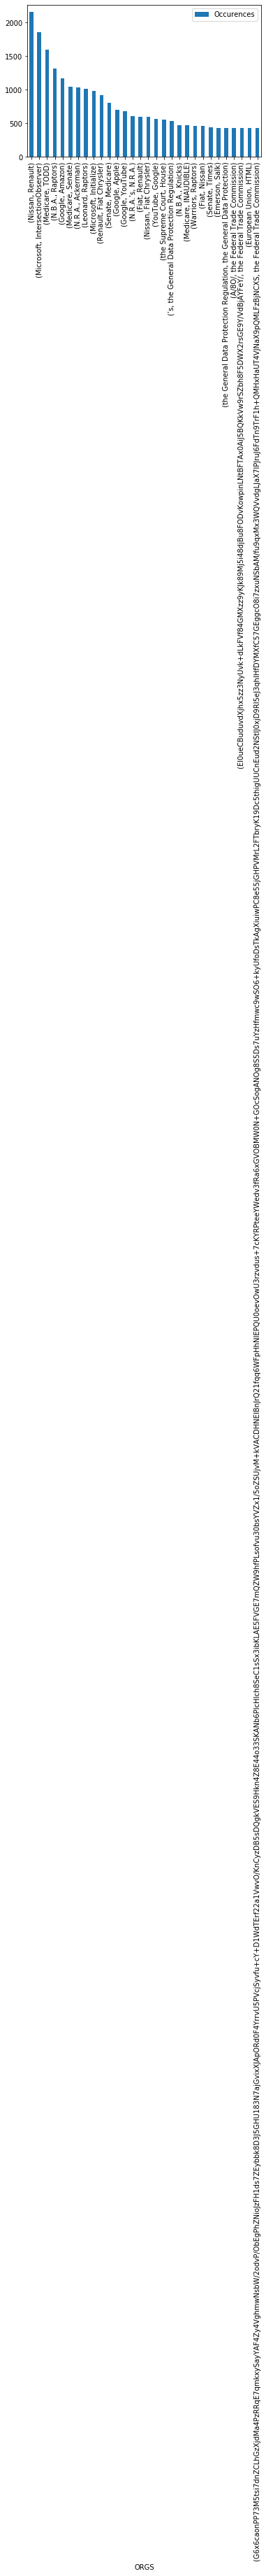

In [124]:
df_no45 = df[['Trump' not in x for x in df.ORGS]]
df_no45 = df_no45[['E.U.' not in x for x in df_no45.ORGS]]
df_no45 = df_no45[['the White House' not in x for x in df_no45.ORGS]]
df_no45 = df_no45[['the European Union' not in x for x in df_no45.ORGS]]
df_no45 = df_no45[['Congress' not in x for x in df_no45.ORGS]]
df_no45 = df_no45[["&&" not in x for x in df_no45.ORGS]]
df_no45 = df_no45[['NYT' not in x for x in df_no45.ORGS]]


df_no45[:30].plot(kind='bar', x = 'ORGS')


In [128]:
df_no45 = df_no45[df_no45['ORGS'].apply(lambda x: True if len(x[0]) < 20 and len(x[1]) < 20 else False)]

df_no45['ORGS'][6][0]

'Nissan'

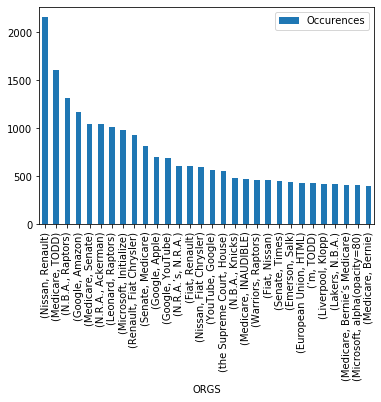

In [129]:
df_no45[:30].plot(kind='bar', x = 'ORGS')

In [145]:
single_totals = {}
for index, row in df_no45.iterrows():
    if row.ORGS[0] not in single_totals:
        single_totals[row.ORGS[0]] = row.Occurences
    else:
        single_totals[row.ORGS[0]] += row.Occurences
    if row.ORGS[1] not in single_totals:
        single_totals[row.ORGS[1]] = row.Occurences
    else:
        single_totals[row.ORGS[1]] += row.Occurences

print(single_totals)

{'Nissan': 5244, 'Renault': 5570, 'Medicare': 11234, 'TODD': 5178, 'N.B.A.': 7613, 'Raptors': 7984, 'Google': 10683, 'Amazon': 7237, 'Senate': 10543, 'N.R.A.': 2649, 'Ackerman': 1539, 'Leonard': 3069, 'Microsoft': 9793, 'Initialize': 1328, 'Fiat Chrysler': 2324, 'Apple': 6737, 'YouTube': 3855, 'N.R.A.’s': 951, 'Fiat': 2469, 'the Supreme Court': 4234, 'House': 7662, 'Knicks': 2280, 'INAUDIBLE': 1936, 'Warriors': 1072, 'Times': 11431, 'Emerson': 1163, 'Salk': 1268, 'European Union': 3423, 'HTML': 2254, '’m': 4646, 'Liverpool': 2923, 'Klopp': 3380, 'Lakers': 2318, 'Bernie’s Medicare': 507, 'alpha(opacity=80': 524, 'Bernie': 781, 'Obamacare': 1248, 'Google’s': 1106, 'White House': 6282, 'YouTube’s': 375, 'Nets': 941, 'ePrivacy Directive': 2461, 'The New York Times': 9406, 'NYT Cooking': 1130, 'UMG': 8503, 'MCA': 497, 'Yankees': 4414, 'Urshela': 632, 'Champions League': 2731, 'Boeing': 3017, 'MCAS': 548, 'The New York': 4229, 'A&M': 334, 'Liverpool’s': 1445, 'Fox': 1498, 'Fox News': 2036, '

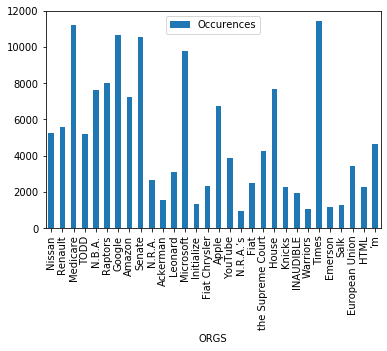

In [157]:
df_totals = pd.DataFrame([single_totals.items()][0], columns = ['ORGS', 'Occurences'])

df_totals[:30].plot(kind='bar', x = 'ORGS')